# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

## Цель

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

## Задачи

1. Построить модель с предельно большим значением F1-меры. 
1. Нужно довести метрику до 0.59. 
1. Проверить F1-меру на тестовой выборке.
1. Дополнительно измерить AUC-ROC и сравнивайте её значение с F1-мерой.

## Загрузка необходимых библиотек и данных

In [1]:
from copy import deepcopy

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, ParameterGrid, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [2]:
try:
    from imblearn.over_sampling import ADASYN, SMOTE
    from imblearn.under_sampling import ClusterCentroids
except:
    !pip install imblearn
    from imblearn.over_sampling import ADASYN, SMOTE
    from imblearn.under_sampling import ClusterCentroids

     |████████████████████████████████| 189 kB 1.2 MB/s eta 0:00:01


In [3]:
plt.rcParams["figure.figsize"] = (12, 8)

In [4]:
from graphviz import Source
from IPython.display import HTML, SVG, display

In [5]:
style = "<style>svg{width:70%!important; height: 70%!important;}</style>"
HTML(style);

In [6]:
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", 100)
pd.options.mode.chained_assignment = None

In [7]:
try:
    df = pd.read_csv("./Churn.csv")
except FileNotFoundError:
    df = pd.read_csv("/datasets/Churn.csv")

In [8]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Обращают на себя внимание пропуски в колонке `Tenure`. 

Кроме того, ряд признаков является по смыслу категориальными, но закодированы строками: `Geography`, `Gender`

In [10]:
df["Geography"].unique(), df["Gender"].unique()

(array(['France', 'Spain', 'Germany'], dtype=object),
 array(['Female', 'Male'], dtype=object))

In [11]:
df.duplicated().sum()

0

Дубликаты в данных отсутствуют.

## Подготовка данных

### Преобразование категориальных признаков

Прежде всего, преобразуем категориальные переменные к широкому формату: 

In [12]:
df = pd.get_dummies(df, drop_first=True, columns=["Gender", "Geography"])

In [13]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,1,15634602,Hargrave,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1


### Работа с пропусками

Посмотрим, как распределены значения `Tenure`. Формально признак `Tenure` имеет тип float, но по факту это целые значения, так что для построения распределения можно воспользоваться обычной гистограммой

In [14]:
df["Tenure"].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

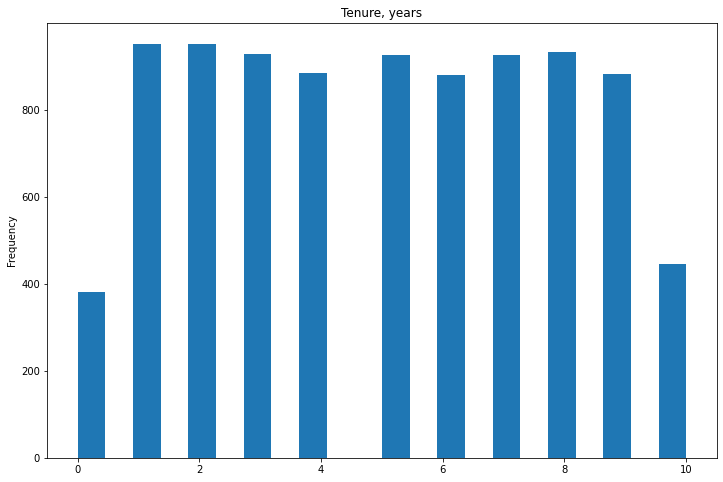

In [15]:
df["Tenure"].plot(kind="hist", title="Tenure, years", ylabel="Frequency", bins=22);

Видно, что на интервале от 0 до 10 лет распределение практически равномерное с некоторым провалом на 0 лет (очевидно, фактор неполного года) и на 10 годах (возможно, самому банку 10 лет и первый год так же был неполным).

Посмотрим, как ведут себя другие числовые признаки при заполеннном и незаполненном признаке `Tenure`:

In [16]:
columns = [
    "CreditScore",
    "Age",
    "Balance",
    "HasCrCard",
    "IsActiveMember",
    "Exited",
    "Gender_Male",
    "Geography_Germany",
    "Geography_Spain",
    "EstimatedSalary",
    "NumOfProducts",
]
df[columns].describe()

,CreditScore,Age,Balance,HasCrCard,IsActiveMember,Exited,Gender_Male,Geography_Germany,Geography_Spain,EstimatedSalary,NumOfProducts
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0,10000.00,10000.00,10000.00,10000.00,10000.00
mean,650.53,38.92,76485.89,0.71,0.52,0.2,0.55,0.25,0.25,100090.24,1.53
std,96.65,10.49,62397.41,0.46,0.50,0.4,0.50,0.43,0.43,57510.49,0.58
min,350.00,18.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,11.58,1.00
25%,584.00,32.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,51002.11,1.00
50%,652.00,37.00,97198.54,1.00,1.00,0.0,1.00,0.00,0.00,100193.91,1.00
75%,718.00,44.00,127644.24,1.00,1.00,0.0,1.00,1.00,0.00,149388.25,2.00
max,850.00,92.00,250898.09,1.00,1.00,1.0,1.00,1.00,1.00,199992.48,4.00


In [17]:
df[df["Tenure"].isna()][columns].describe()

,CreditScore,Age,Balance,HasCrCard,IsActiveMember,Exited,Gender_Male,Geography_Germany,Geography_Spain,EstimatedSalary,NumOfProducts
count,909.00,909.00,909.00,909.00,909.00,909.0,909.00,909.00,909.00,909.00,909.00
mean,648.45,38.65,76117.34,0.71,0.51,0.2,0.53,0.24,0.25,99180.39,1.53
std,99.08,9.79,63105.69,0.45,0.50,0.4,0.50,0.43,0.43,56378.06,0.59
min,359.00,18.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,106.67,1.00
25%,580.00,32.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,49872.33,1.00
50%,647.00,37.00,96674.55,1.00,1.00,0.0,1.00,0.00,0.00,99444.02,1.00
75%,718.00,43.00,128554.98,1.00,1.00,0.0,1.00,0.00,1.00,145759.70,2.00
max,850.00,92.00,206663.75,1.00,1.00,1.0,1.00,1.00,1.00,199390.45,4.00


Видно, что статистические характеристики признаков в полной выборке очень близки к таковым наблюдений с пропусками в `Tenure`. Это указывает на то, что пропуски в данном признаки достаточно случайны и в случае отбрасывания наблюдений с пропусками статистики оставшейся выборки будут соответствовать генеральной совокупности. 

In [18]:
df = df.dropna(axis=0)
df.shape

(9091, 15)

### Нормализация данных  

Разделим фичи и целевой признак. Такие признаки как фамилия, индекс строки и идентификатор пользователя вряд ли имеют прогностическую силу, поэтому исключим их из исписка признаков.

In [19]:
X = df.drop(["Exited", "RowNumber", "CustomerId", "Surname"], axis=1)
y = df["Exited"]

Посмотрим на характерные значения разных признаков:

In [20]:
X.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
count,9091.00,9091.00,9091.00,9091.00,9091.00,9091.00,9091.00,9091.00,9091.00,9091.00,9091.00
mean,650.74,38.95,5.00,76522.74,1.53,0.70,0.52,100181.21,0.55,0.25,0.25
std,96.41,10.56,2.89,62329.53,0.58,0.46,0.50,57624.76,0.50,0.43,0.43
min,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00,0.00,0.00
25%,584.00,32.00,2.00,0.00,1.00,0.00,0.00,51227.74,0.00,0.00,0.00
50%,652.00,37.00,5.00,97318.25,1.00,1.00,1.00,100240.20,1.00,0.00,0.00
75%,717.00,44.00,7.00,127561.89,2.00,1.00,1.00,149567.21,1.00,1.00,0.00
max,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00,1.00,1.00


Видно, что разные признаки имеют сильно разные характерные значения: `CreditScore` имеет значения в диапазоне [350,850], `Age`&nbsp;&mdash; [18,92], `Balance`&nbsp;&mdash; [0,250898.09], `EstimatedSalary`&nbsp;&mdash; [11.58,199992.48], а множество других (`HasCrCard`, `IsActiveMember`, `Exited`, `Gender_Male`, `Geography_Germany`, `Geography_Spain`)&nbsp;&mdash; [0,1]. 

Это приводит к тому, что признаки дают разный вклад в прогноз модели. Поэтому все числовые данные нужно привести к одному масштабу. Для этого можно воспользоваться классом StandardScaler из библиотеки `sklearn`. Он приводит значения к нулевому среднему и единичной дисперсии. Это не очень подходит для наших данных: у нас уже есть целый ряд признаков со значениями в диапазоне [0,1]. Поэтому нам лучше подойдёт класс `MinMaxScaler`, который приводит значения в диапазон [0,1]

In [21]:
scaler = MinMaxScaler()

Остаётся построить тренировочную, валидационную и тестовую выборки. Разобьём данные в отношении 60%, 20%, 20%, соответственно.

In [22]:
X_work, X_test, y_work, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_work, y_work, test_size=0.25, random_state=42
)

In [24]:
X_train.shape[0], X_valid.shape[0], X_test.shape[0]

(5454, 1818, 1819)

In [25]:
num_cols = ["CreditScore", "Age", "Balance", "EstimatedSalary", "NumOfProducts"]
scaler.fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_valid[num_cols] = scaler.transform(X_valid[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [26]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
4440,0.72,0.19,9.0,0.40,0.00,1,0,0.83,1,0,0
6866,0.65,0.19,8.0,0.79,0.00,1,1,0.26,1,0,1
9257,0.66,0.26,8.0,0.59,0.33,1,1,0.11,0,1,0
3223,0.85,0.28,2.0,0.42,0.00,0,0,0.40,1,0,1
1085,0.91,0.32,5.0,0.00,0.00,1,0,0.98,1,0,0


## Исследование задачи

Классы в задаче имеют разные мощности:

In [27]:
y.value_counts(normalize=True)

0    0.8
1    0.2
Name: Exited, dtype: float64

Если бы основным критерием был `ROC AUC`, то несбалансированность классов не имела бы особого значения, но F1-мера чувствительна к дисбалансу.

Но для начала построим модель на данных "как есть".

In [28]:
rf_simple = RandomForestClassifier(random_state=42).fit(X_train, y_train)
f1_score(y_valid, rf_simple.predict(X_valid))

0.567741935483871

Полученая F1-мера ниже требуемой величины, но минимальным подбором гиперпараметров это можно исправить:

In [29]:
best_est = 0
best_score = 0

for est in range(1, 250 + 2, 50):
    rf_simple = RandomForestClassifier(
        random_state=42, n_jobs=-1, n_estimators=est
    ).fit(X_train, y_train)
    score = f1_score(y_valid, rf_simple.predict(X_valid))
    if best_score < score:
        best_est = est
        best_score = score
best_est, best_score

(201, 0.5945945945945946)

Искомое значение уже выше 0,59 получено, но насколько высокое значение F1-меры соотностится с прогностической силой модели, обученной на несбалансированных классах? 

В принципе, в классификаторе `RandomForestClassifier` есть встроенный инструмен, позволяющий снизить дисбаланс. Для этого используется параметр `class_weight='balanced'`, который присваивает членам классов разные веса в зависимости от мощностенй классов: 1 для представителей класса 0 и $m_0 / m_1$ для класса 1, где $m_0$, $m_1$ - количество элементов в классах 0 и 1.

In [30]:
rf_bln = RandomForestClassifier(
    random_state=42, n_estimators=200, class_weight="balanced"
).fit(X_train, y_train)
f1_score(y_valid, rf_bln.predict(X_valid))

0.5691056910569106

Видно, что учёт несбалансированности классов привёл к уменьшению F1-меры. Это означает, что балансировкой классов надо заниматься более основательно.

### Вывод

На данных с проблемой дисбаланса классов была обучена простая модель случайного леса с минимальным тюнингом гиперпараметров. Формальгл, полученное значение F1-меры достаточно велико, но демонстрирует признаки неустойчивости. Проведём балансировку данных.

## Борьба с дисбалансом

Как уже было установлено среди клиентов банка большая часть нашей выборки остаётся клиентами банка (80%), тогда как существенно меньшая часть (20%) покинули банк. В идеально сбалансированной ситуации количество элементов каждого класса должно быть равно, что не соответсвует нашему случаю. 

Выхода у нас два: увеличивать количество элементов класса 1 (oversampling) или уменьшать количество элементов класса 0 (undersampling).

Достоинством первого подхода является то, что в обучении принимают участие все представители класса 0, то есть все исходные данные. Можно ожидать, что и качество результирующей модели будет выше. Во втором случае обучение модели происходит на частичных данных. Но это даёт возможность строить целый ансамбль таких частичных моделей и усреднять их. 

### Oversampling

Начнём с расширения выборки. Способов достич цели существует много. В простейшем случае можно просто случайным образом дублировать записи из класса 1. Но существует библиотека `imblearn`, в которой реализованы разные методы oversampling. Одним из наиболее эффективных является `ADASYN` (Adaptive Synthetic), который на основе информации о ближайших соседях элементов малого класса достраивает новые элементы "подобные" имеющимся (Haibo He, Yang Bai, Edwardo A Garcia, and Shutao Li. Adasyn: adaptive synthetic sampling approach for imbalanced learning). 

In [31]:
X_over, y_over = ADASYN().fit_resample(X_train, y_train)

In [32]:
y_over.value_counts(normalize=True)

0    0.51
1    0.49
Name: Exited, dtype: float64

Попробуем повторить опыт со случайным лесом с параметрами по умолчанию с балансировкой весов и без уже на сбалансированных данных. 

In [33]:
rf_ovr = RandomForestClassifier(random_state=42).fit(X_over, y_over)
f1_score(y_valid, rf_ovr.predict(X_valid))

0.6110363391655451

In [34]:
rf_ovr_bln = RandomForestClassifier(random_state=42, class_weight="balanced").fit(
    X_over, y_over
)
f1_score(y_valid, rf_ovr_bln.predict(X_valid))

0.607764390896921

По сравнению со случаем несбалансированных классов, мы имеем практически то же значение F1-меры, а также устойчивость к балансировке весов, что не удивительно.

### Undersamplung


Теперь рассмотрим второй способ балансировки классов: снижением количества записей большого класса.

Здесь так же возможно "наивное" решение в виде выбрасывания случайных элементов класса 0. Но нам на помощь снова приходит библиотека `imblearn` с функцией `under_sampling.ClusterCentroids`, построенная на кластерном алгоритме `KMean`. Главный недостаток данного алгоритма - медленное обучение

In [35]:
%%time

X_under, y_under = ClusterCentroids(random_state=42).fit_resample(X, y)

CPU times: user 1min 33s, sys: 2min 32s, total: 4min 5s
Wall time: 22 s


In [36]:
y_under.value_counts(normalize=True)

0    0.5
1    0.5
Name: Exited, dtype: float64

In [37]:
rf_und = RandomForestClassifier(random_state=42).fit(X_under, y_under)
f1_score(y_valid, rf_und.predict(X_valid))

0.3131707317073171

In [38]:
rf_und_bln = RandomForestClassifier(random_state=42).fit(X_under, y_under)
f1_score(y_valid, rf_und_bln.predict(X_valid))

0.3131707317073171

Как и следовало ожидать, лучший результат был получен на большей выборке oversampling. В таком случае, используем именно этот набор данных для более тонкой настройки нашего случайного леса. 

### Настройка модели

Пришло время оттюнинговать нашу модель случайного леса, подобрав ей гиперпараметры. Обёчать её будеи на основе расширенной выборки.

Построим итератор для подбора гиперпараметров случайного леса. В качество таких гиперпараметров используем максимальную глубину дерева, количество деревьев и минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться. 

In [39]:
%%time

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
best_score = 0
best_rf = None

for prm in ParameterGrid(
    {
        "n_estimators": range(1, 150 + 1, 30),
        "min_samples_split": range(3, 10 + 1, 2),
        #         "max_depth": range(1, 31 + 1, 5),
    }
):
    rf.set_params(**prm)
    rf.fit(X_over, y_over)
    score = f1_score(y_valid, rf.predict(X_valid))
    if best_score < score:
        best_score = score
        best_rf = deepcopy(rf)

CPU times: user 11.9 s, sys: 179 ms, total: 12.1 s
Wall time: 2.73 s


In [40]:
print(f"F1: {best_score}")
print(f"best params: {best_rf.get_params()}")

F1: 0.6218034993270525
best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 121, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [41]:
print(best_rf)

RandomForestClassifier(min_samples_split=7, n_estimators=121, n_jobs=-1,
                       random_state=42)


Зафиксируем количество деревьев в лесу и настроим два других гиперапараметра в малой окрестности от наилучшего найденного значения:

In [42]:
%%time

for prm in ParameterGrid(
    {
        "n_estimators": [121],
        "min_samples_split": range(5, 10 + 1, 1),
        "max_depth": range(1, 20 + 1, 4),
    }
):
    rf.set_params(**prm)
    rf.fit(X_over, y_over)
    score = f1_score(y_valid, rf.predict(X_valid))
    if best_score < score:
        best_score = score
        best_rf = deepcopy(rf)

CPU times: user 24.8 s, sys: 980 ms, total: 25.8 s
Wall time: 6.88 s


In [43]:
print(f"F1: {best_score}")
print(f"best params: {best_rf.get_params()}")

F1: 0.6230303030303029
best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 121, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Теперь подберём оптимальное количество деревьев:

In [44]:
%%time

for prm in ParameterGrid(
    {
        "n_estimators": range(70, 170 + 1, 10),
        "min_samples_split": [15],
        "max_depth": [9],
    }
):
    rf.set_params(**prm)
    rf.fit(X_over, y_over)
    score = f1_score(y_valid, rf.predict(X_valid))
    if best_score < score:
        best_score = score
        best_rf = deepcopy(rf)

CPU times: user 9.91 s, sys: 248 ms, total: 10.2 s
Wall time: 2.5 s


In [45]:
print(f"F1: {best_score}")
print(f"best params: {best_rf.get_params()}")

F1: 0.6259168704156479
best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 90, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Мы получили модель случайного леса с наилучшим значением F1-меры: 

In [46]:
rf_model = deepcopy(best_rf)

Полученное значение F1-меры уже соответсвует заданным условиям. Посмотрим на значение ROC-AUC: 

In [47]:
prob_valid = rf_model.predict_proba(X_valid)
prob_valid = prob_valid[:, 1]
roc_auc_score(y_valid, prob_valid)

0.8674700141756251

Построим ROC-кривую:

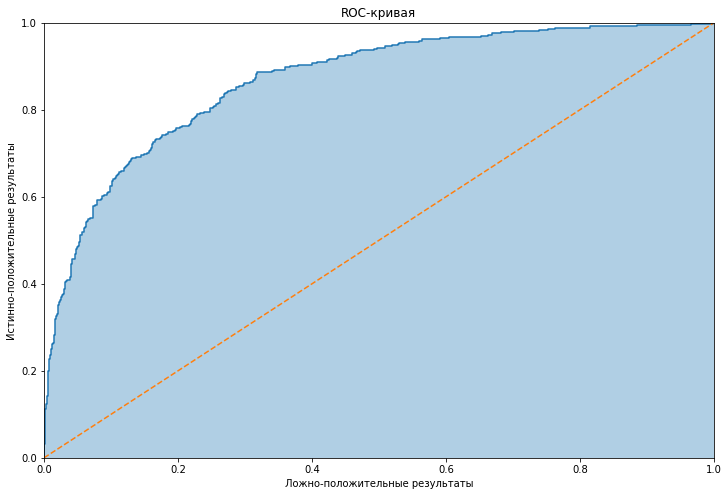

In [48]:
fpr, tpr, thresholds = roc_curve(y_valid, prob_valid)

plt.plot(fpr, tpr, linestyle="-")
plt.fill_between(fpr, tpr, alpha=0.35)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("Ложно-положительные результаты")
plt.ylabel("Истинно-положительные результаты")
plt.title("ROC-кривая")
plt.show()

AUC-значение говорит о том, что наша модель предсказывает лучше случайной модели (представлена на графике ROC-кривой оранжевой пунктирной линией).

## Тестирование модели

Осталось проверить, как себя поведёт наша модель на новых данных, с которыми она до того не сталкивалась. На это случай мы подготовили тестовый набор. Посмотрим какие значения F1-метрики и AUC на тестовой выборке: 

In [49]:
f1_valid = f1_score(y_valid, rf_model.predict(X_valid))
f1_test = f1_score(y_test, rf_model.predict(X_test))
print(f"F1(valid): {f1_valid}")
print(f"F1(test): {f1_test}")
print(f"F1(delta): {(f1_valid-f1_test)/f1_valid*100:.02f}%")

F1(valid): 0.6259168704156479
F1(test): 0.6060606060606061
F1(delta): 3.17%


Важно, что на тестовой и валидационной выборках получены очень близкие результат: снижение оказалось менее 4%. Но в обоих случаях F1-мера выше требуемых 0,59. 

Вычислим теперь значение AUC на тестовой выборке и сравним его со сзначением на валидационной выборке:

In [50]:
prob_test = rf_model.predict_proba(X_test)
prob_test = prob_test[:, 1]
auc_valid = roc_auc_score(y_valid, prob_valid)
auc_test = roc_auc_score(y_test, prob_test)
print(f"AUC(valid): {auc_valid}")
print(f"AUC(test): {auc_test}")
print(f"AUC(delta): {(auc_valid-auc_test)/auc_valid*100:.02f}%")

AUC(valid): 0.8674700141756251
AUC(test): 0.8489665636622689
AUC(delta): 2.13%


Как видим, значение F1-меры снизилось менее чем на 2%, снижение AUC-значение оказалось ещё меньше.

Построим для тестовой выборки ROC-кривую

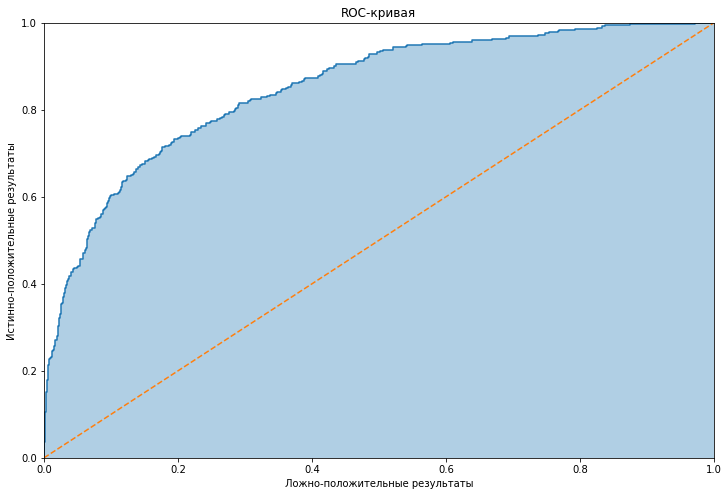

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, prob_test)

plt.plot(fpr, tpr, linestyle="-")
plt.fill_between(fpr, tpr, alpha=0.35)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("Ложно-положительные результаты")
plt.ylabel("Истинно-положительные результаты")
plt.title("ROC-кривая")
plt.show()

## Выводы

Для создания модели предсказания оттока клиентов банка была проведена подготовка входных данных:
1. удалены записи с пропусками в колонке Tenure;
1. оставшийся массив данных разделён на обучающую, валидационную и тестовую выборки;
1. числовые признаки были нормализованы с тем, чтобы признаки с большими абсолютными значениями не подавляли, значимые, но небольшие в абсолютном выражении признаки.

После этого была проведена работа по балансировке данных с тем, чтобы ни один из двух классов участников выборки (те, кто остался клиентом банка, и те, кто ушёл) не имели значительного численного перевеса. В данном случае наилучшие результаты показал метод прореживания лояльных клиентов.

Наконец было проведено обучение модели случайного леса и тюнинг её гиперпараметров с целью получения наивысшего значения F1-меры, которая в итоге оказалась равна 0.634, что выше требуемого 0,59. значение ROC-AUC оказалось 0.93, что говорит о том, что прогностическая способность нашей модели существенно превосходит возможности случайной модели, которая должна была дать ROC-AUC=0,5.

Наконец, полученная модель была проверена на тестовой выборке и продемонстрировала устойчивость своих показателей: F1-мера снизилась на тестовой выборке менее, чем на 4%, что говорит об устойчивости модели и даёт надежду на то, что модель не является переобученной или недообученной. 